In [1]:
using OffsetArrays, Parameters, Plots, ForwardDiff, NLsolve, SpecialFunctions, BenchmarkTools, LinearAlgebra
using ForwardDiff: jacobian, derivative

In [2]:
gr(fmt = :png);

# Model specification

In [3]:
N_ks = (5, 5)  # number of firms per quality group H and L
q = range(2.0, 3.0, length = length(N_ks)) 

N = sum(N_ks)
k_bar = length(N_ks) # number of quality types
cohorts = (N, ) # cohorts
b_bar = length(cohorts) # number of cohorts
f = fill(1/((N+1)^b_bar), (N+1)^b_bar); # awareness set distribution

In [4]:
σ = 0.15 # baseline value calibrated from main paper
κ = 3.5 # baseline value calibrated from main paper
params = (cohorts = cohorts, Γ_bar = gamma(1-σ*(κ-1))^(1/(1-κ)) , Ω = 1.0, q = q, σ = σ, κ = κ, mc = 1.0, N_ks = N_ks)

(cohorts = (10,), Γ_bar = 0.865600495724366, Ω = 1.0, q = 2.0:1.0:3.0, σ = 0.15, κ = 3.5, mc = 1.0, N_ks = (5, 5))


# Demand function with 2-type firms

In [5]:
k = 1 # the quality type firm i belongs to
p = fill(1.0, k_bar); # k_bar-vector of prices

## Demand with 2-type under a single cohort

Consider firms belonging to one of the two types $L$ and $H$ with different qualities $q_L$ and $q_H$. An awareness set can be represented as $n = (N_L, N_H)$ where $N_L$ and $N_H$ denote the number of firms awared from $L$ and $H$ types respectively.

Given the awareness set distribution $f$, firm $i$ on $H$ type faces demand
$$
y_{i}(p_i, p_{-i}, f) 
=  \bar{\Gamma}^{1-\kappa}\Omega \, q_H^{1/\sigma}p_i^{-1/\sigma - 1}\, \cdot \\ 
\sum_{n \in \mathcal{N} } f_n   \sum_{n_H =1}^n  
\dfrac{n_H}{N_H}  \dfrac{\binom{N_H}{n_H} \binom{N_L}{n - n_H}}{\binom{N_H + N_L}{n}}
\left( 
n_H \left( \dfrac{p_{H}}{q_{H}}   \right)^{-1/\sigma} +  
(n - n_H) \left( \dfrac{p_{L}}{q_{L}}   \right)^{-1/\sigma} +
\dfrac{p_i^{-1/\sigma} - p^{-1/\sigma}_{H} }{ q_H^{-1/\sigma }} 
\right)^{\sigma (\kappa - 1)-1}
$$

In [6]:
# Demand function with 2-type under a single cohort
# p_i: the price of product of firm i (can be different from p[k])
# k: the qualtity type firm i belongs to
# p: k_bar-vector of prices across firms
# f: awareness set distribution on 1:(N+1)
# params: model parameters
# n: awareness set in 1:(N+1)
# n_k: number of k-type firms awared such that n_k <= n
function demand_summand(p_i, k, p, f, params, n, n_k)
    @unpack cohorts, q, σ, κ, N_ks = params
    N = sum(N_ks)
    k_other = k == 1 ? 2 : 1
    n_1 = k == 1 ? n_k : N - n_k
    n_2 = N - n_1
    
    weight = (n_k / N_ks[k]) * (binomial(N_ks[k], n_k) * binomial(N_ks[k_other], n - n_k) / binomial(N, n))
    summands = [n_1; n_2] .* (p ./ q).^(-1/σ)
    return weight * (sum(summands) + (p_i^(-1/σ) - p[k]^(-1/σ)) / (q[k])^(-1/σ))^(σ*(κ-1)-1)
end

function demand(p_i, k, p, f, params)
    @unpack cohorts, Γ_bar, Ω, q, σ, κ, N_ks = params
    N = sum(N_ks)
    k_bar = length(cohorts)
    
    f = reshape(f, Tuple(fill(0:N, k_bar)))
    demand_value = 0

    # only first cohort
    for n in CartesianIndices(f)
        if (n[1] > 0)
            demand_value += f[n] * sum((n_k -> demand_summand(p_i, k, p, f, params, n[1], n_k)).(1:n[1]))
        end
    end
    return Γ_bar^(1-κ)*Ω*q[k]^(1/σ)*p_i^(-1/σ-1) * demand_value
end

profit(p_i, k, p, f, params) = (p_i - params.mc) * demand(p_i, k, p, f, params)
profit_derivative(p_i, k, p, f, params) = derivative(p_i -> profit(p_i, k, p, f, params), p_i)

profit_derivative (generic function with 1 method)

## Extension: Demand with 2-type under multiple cohorts

Consider firms belonging to one of the two types $L$ and $H$ with different qualities $q_L$ and $q_H$. An awareness set can be represented as $n = (N_L, N_H)$ where $N_L$ and $N_H$ denote the number of firms awared from $L$ and $H$ types respectively.

Given the awareness set distribution $f$, firm $i$ of type $k$ in $b$ cohort faces demand

\begin{equation}\label{eq:full-total-demand-two-quality-multiple-cohort-alternative}
\begin{aligned}
& y_{ikb}(p_i, p_{-i}, f) 
=  \bar{\Gamma}^{1-\kappa}\Omega \, q_k^{1/\sigma}p_i^{-1/\sigma - 1}\, \dfrac{1}{N_k} \cdot  \\ 
& \quad \sum_{n \in \mathcal{N} } f_n   \sum_{n_k \in \mathcal{V} (n) }  
\Bigg\{
\left[ n_{kb} \prod_{b'=1}^{\bar b} 
 \dfrac{\binom{N_k}{n_{kb'}} \binom{N_{-k}}{n_{b'} - n_{kb'}}}{\binom{N_k + N_L}{n_{b'}}}
\right] \cdot \\ & \quad
\Bigg[
\sum_{b' = 1}^{\bar b} 
\left(
n_{kb'} \left( \dfrac{p_{kb}}{q_{k}}   \right)^{-1/\sigma} +  
(n - n_{kb'}) \left( \dfrac{p_{(-k)b}}{q_{-k}}   \right)^{-1/\sigma} \right) + 
\dfrac{p_i^{-1/\sigma} - p^{-1/\sigma}_{kb} }{ q_k^{-1/\sigma }} 
\Bigg]^{\sigma (\kappa - 1)-1} \Bigg\}
\end{aligned}
\end{equation}


In [7]:
k = 1 # the quality type firm i belongs to
p = fill(1.0, k_bar, b_bar); # k_bar-vector of prices

In [8]:
# Demand function with 2-type under a single cohort
# p_i: the price of product of firm i (can be different from p[k])
# k: the qualtity type firm i belongs to
# b: the cohort firm i belongs to
# p: k_bar by b_bar matrix of prices across qualities and cohorts
# f: awareness set distribution on 1:(N+1)
# params: model parameters
# n: k_bar-vector of whose each element is in 1:N
# n_k: number of k-type firms awared such that n_k <= n
function demand_summand(p_i, k, b, p, f, params, n, n_k)
    @unpack cohorts, q, σ, κ, N_ks = params
    b_bar = length(cohorts)
    N = sum(N_ks)
    
    k_other = k == 1 ? 2 : 1
    n_k1 = k == 1 ? Tuple(n_k) : N .- Tuple(n_k) # b_bar-vector representing 1st elements of n_k
    n_k2 = N .- n_k1 # b_bar-vector representing 2nd elements of n_k
    
    # given b_, compute the probability of choosing n_k[b_] (hypergeometric distribution)
    choose_n_kb_(b_) = (binomial(N_ks[k], n_k[b_]) * binomial(N_ks[k_other], n[b_] - n_k[b_]) / 
                        binomial(N, n[b_]))
    # probability that firm i is awared and n_k firms are awared out of type k
    weight = (n_k[b] / N_ks[k]) * prod(choose_n_kb_.(1:b_bar))
    # sum on p/q over all cohorts and types
    summands = [n_k1 .* (p[1,:] ./ q[1]).^(-1/σ);
                n_k2 .* (p[2,:] ./ q[2]).^(-1/σ)]
    return weight * (sum(sum.(summands)) + (p_i^(-1/σ) - p[k,b]^(-1/σ)) / (q[k])^(-1/σ))^(σ*(κ-1)-1)
end

function demand(p_i, k, b, p, f, params)
    @unpack cohorts, Γ_bar, Ω, q, σ, κ, N_ks = params
    N = sum(N_ks)
    b_bar = length(cohorts)
    
    f = reshape(f, Tuple(fill(0:N, b_bar)))
    V_ns = CartesianIndices(Tuple(fill(0:N, b_bar))) # ⋃_n {V(n)}
    demand_value = 0
    for n in CartesianIndices(f)
        if (n[b] > 0)
            # extract V(n) by finding n_k in V_ns such that n_k <= n (elementwise) is true
            V_n = V_ns[(n_k -> n_k <= n).(V_ns)] 
            # use v_k in V(n) such that v_k[b] > 0 (i.e., firm i in b cohort can be awared)
            V_n = V_n[(n_k -> n_k[b] > 0).(V_n)]
            demand_value += f[n] * sum((n_k -> demand_summand(p_i, k, b, p, f, params, n, n_k)).(V_n))
        end
    end
    return Γ_bar^(1-κ)*Ω*q[k]^(1/σ)*p_i^(-1/σ-1) * demand_value
end

profit(p_i, k, b, p, f, params) = (p_i - params.mc) * demand(p_i, k, b, p, f, params)
profit_derivative(p_i, k, b, p, f, params) = derivative(p_i -> profit(p_i, k, b, p, f, params), p_i)

profit_derivative (generic function with 2 methods)

### Sanity check: test if multiple cohort demand nests one cohort demand

In [9]:
b = 1
for k in 1:2
    for p_i in 1.0:.1:3.0
        @assert demand(p_i, k, p, f, params) ≈ demand(p_i, k, b, p, f, params) 
    end
end

## Plots

In [10]:
# two cohorts
cohorts = (N, N, ) # cohorts
b_bar = length(cohorts) # number of cohorts
p = fill(1.0, k_bar, b_bar)
half_size = Int64(round((N+1)^b_bar/2))
f = [fill(0.0, half_size+1); fill(1/half_size, half_size)] # note that f is not uniform
params = merge(params, (cohorts = cohorts,))

(cohorts = (10, 10), Γ_bar = 0.865600495724366, Ω = 1.0, q = 2.0:1.0:3.0, σ = 0.15, κ = 3.5, mc = 1.0, N_ks = (5, 5))

### Demand

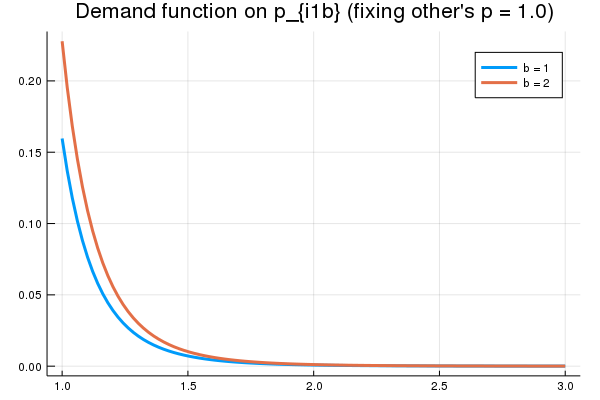

In [11]:
# plot the demand functions for k = 1
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> demand(p_i, 1, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Demand function on p_{i1b} (fixing other's p = 1.0)")

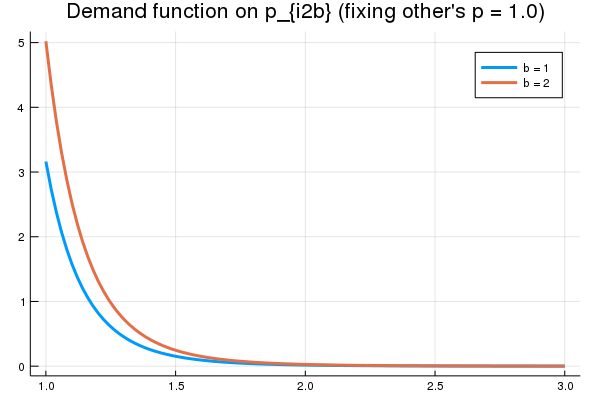

In [12]:
# plot the demand functions for k = 2
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> demand(p_i, 2, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Demand function on p_{i2b} (fixing other's p = 1.0)")

### Profit

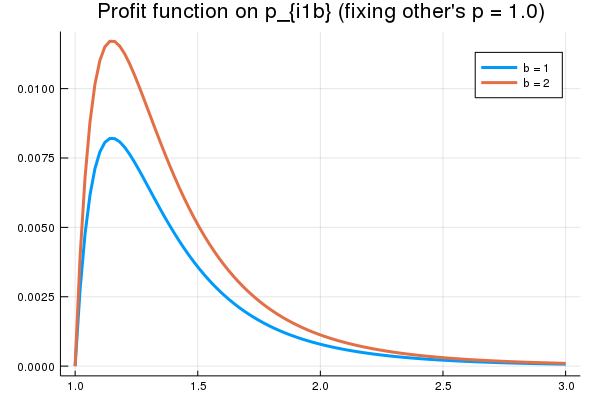

In [13]:
# plot the profit functions for k = 1
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 1, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Profit function on p_{i1b} (fixing other's p = 1.0)")

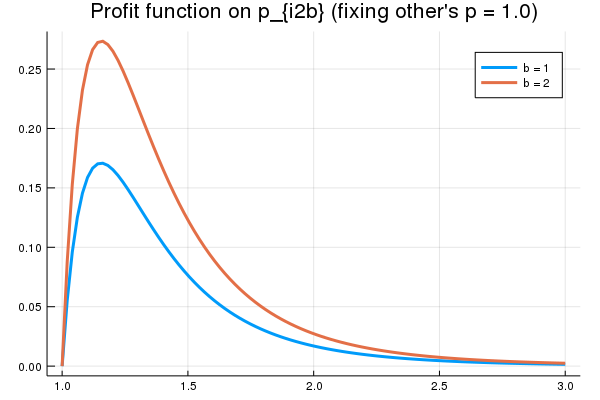

In [14]:
# plot the profit functions for k = 2
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 2, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:b_bar), lw = 3, title = "Profit function on p_{i2b} (fixing other's p = 1.0)")

## Nash equilibria 

In [15]:
flatten(x) = collect(Iterators.flatten(x)) # vectorize matrix

function D_p(p, f, params)
    ks = 1:length(params.N_ks)
    bs = 1:length(params.cohorts)
    # return the vector of derivatives
    return flatten([profit_derivative(p[k,b], k, b, p, f, params) for k in ks, b in bs])
end

function nash_equilibrium(f, params; autodiff=:forward, 
                        iv = fill(params.mc, length(params.N_ks), length(params.cohorts)))
    sol = nlsolve(p -> D_p(p, f, params), iv, autodiff = autodiff)
    return (p = sol.zero, converged = converged(sol), solution = sol)
end

nash_equilibrium (generic function with 1 method)

In [16]:
p = nash_equilibrium(f, params).p # k_bar times b_bar matrix of equilibrium prices

2×2 Array{Float64,2}:
 1.15053  1.15051
 1.16282  1.16473

### Plots

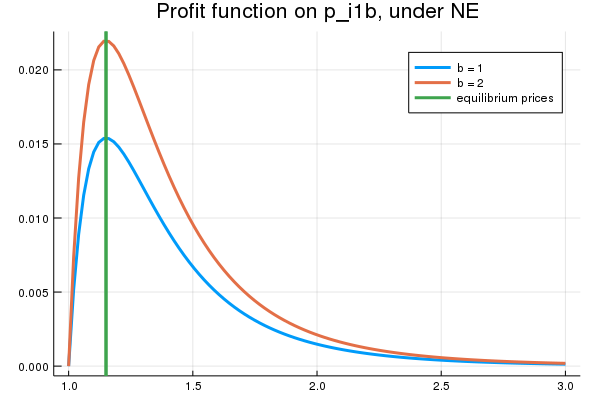

In [17]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 1, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i1b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")

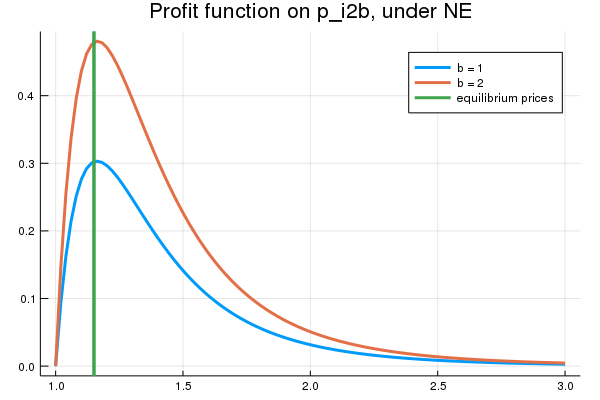

In [18]:
plot(range(1.0,stop=3.0,length=100), (b -> (p_i -> profit(p_i, 2, b, p, f, params))).(1:b_bar),
    label = string.("b = ",1:k_bar), lw = 3, title = "Profit function on p_i2b, under NE")
plot!(p[1,:], st = :vline, lw = 3, label = "equilibrium prices")

### Benchmark: see how efficient the current implementation is

In [19]:
p_i = 1.0
k = 1
b = 1
@show N
@show N_ks

N = 10
N_ks = (5, 5)


(5, 5)

In [20]:
# one cohort
cohorts = (N, ) # cohorts
b_bar = length(cohorts) # number of cohorts
p_cohorts = fill(1.0, k_bar, b_bar)
f = fill(1/((N+1)^b_bar), (N+1)^b_bar); # awareness set distribution
params = merge(params, (cohorts = cohorts,))
@btime demand(p_i, k, b, p_cohorts, f, params)

  107.790 μs (1304 allocations: 122.77 KiB)


0.23428253823258988

In [21]:
# two cohorts
cohorts_2 = (N, N, ) # cohorts
b_bar = length(cohorts_2) # number of cohorts
p_cohorts_2 = fill(1.0, k_bar, b_bar)
f_cohorts_2 = fill(1/((N+1)^b_bar), (N+1)^b_bar); # awareness set distribution
params_cohorts_2 = merge(params, (cohorts = cohorts_2,))
@btime demand(p_i, k, b, p_cohorts_2, f_cohorts_2, params_cohorts_2)

  6.508 ms (86798 allocations: 6.69 MiB)


0.14380357345105405

In [22]:
# three cohorts
cohorts_3 = (N, N, N, ) # cohorts
b_bar = length(cohorts_3) # number of cohorts
p_cohorts_3 = fill(1.0, k_bar, b_bar)
f_cohorts_3 = fill(1/((N+1)^b_bar), (N+1)^b_bar); # awareness set distribution
params_cohorts_3 = merge(params, (cohorts = cohorts_3,))
@btime demand(p_i, k, b, p_cohorts_3, f_cohorts_3, params_cohorts_3)

  961.293 ms (9984958 allocations: 818.69 MiB)


0.10954582300800113

In [23]:
# # four cohorts (can be extremely slow; uncomment it run this cell twice instead of using @btime)
# cohorts_4 = (N, N, N, N, ) # cohorts
# b_bar = length(cohorts_4) # number of cohorts
# p_cohorts_4 = fill(1.0, k_bar, b_bar)
# f_cohorts_4 = fill(1/((N+1)^b_bar), (N+1)^b_bar); # awareness set distribution
# params_cohorts_4 = merge(params, (cohorts = cohorts_4,))
# @time demand(p_i, k, b, p_cohorts_4, f_cohorts_4, params_cohorts_4)